<a href="https://colab.research.google.com/github/Edvandro-Nogueira/TCC-Univesp/blob/main/TCC_Modelo_fakeDETECTOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importações
import pandas as pd
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.svm import SVC
import pickle
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import re
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
#from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#Versão do python
import sys
print(sys.version)

3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


'2.13.0'

In [ ]:
dados_noticias = pd.read_table('https://raw.githubusercontent.com/Edvandro-Nogueira/TCC-Univesp/main/dados_noticias.csv', sep=";")
dados_noticias

,noticias,classe
0,katia abreu diz vai colocar expulsao moldura n...,0
1,ray peita bolsonaro conservador fake entrevist...,0
2,reinaldo azevedo desmascarado policia federal ...,0
3,relatorio assustador bndes mostra dinheiro pub...,0
4,radialista americano fala sobre pt vendem ilus...,0
...,...,...
10753,"Aug 26, 2020 — É falso que neurocientista brit...",0
10754,19/08/2020 - 17:45 / Atualizado em 19/08/2020 ...,0
10755,"Jun 6, 2020 — No Reino Unido, 80% da população...",0
10756,Estudo do pesquisador Karl Friston conclui que...,0


In [ ]:
#Certificamos que existem apenas 2 objetos
dados_noticias['classe'].unique()

array([0, 1])

In [ ]:
#Contando quantos falsos e quantos verdadeiros o dataset possui
contagem = dados_noticias['classe'].value_counts()
print(contagem)

0    6143
1    4615
Name: classe, dtype: int64


###Separando os dados em treino, validação e teste.

In [ ]:
X = dados_noticias["noticias"]
y = dados_noticias["classe"]

# Etapa 1: Separar 90%-10% para teste final
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Etapa 2: Separar 90% restantes em 80%-20% para treinamento e validação
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

# Os dados de treinamento estão em X_train e y_train
# Os dados de validação estão em X_val e y_val
# Os dados de teste final estão em X_test e y_test

####Funções

In [ ]:
#Métricas do F1-score
def f1_score_metrics(model, history):
    train_f1_scores = [f1_score(y_train, (model.predict(train_sequences) > 0.5).astype(int)) for _ in range(len(history.history['accuracy']))]
    val_f1_scores = [f1_score(y_val, (model.predict(val_sequences) > 0.5).astype(int)) for _ in range(len(history.history['accuracy']))]

    return train_f1_scores, val_f1_scores

#Gerar o gráfico com evolução das épocas
def plot_progresso(modelo, history):
    #train_f1_scores, val_f1_scores = f1_score_metrics(modelo, history)

    # Plotar progresso da acurácia e F1-score do modelo durante o treinamento e validação
    plt.plot(history.history['accuracy'], label='Acurácia no treino')
    plt.plot(history.history['val_accuracy'], label='Acurácia na validação')
    plt.plot(train_f1_scores, label='F1-score no treino')
    plt.plot(val_f1_scores, label='F1-score na validação')

    # Exibir os valores de acurácia e F1-score em cada ponto do gráfico
    for i, acc in enumerate(history.history['accuracy']):
        plt.text(i, acc, f"{acc:.4f}", ha='center', va='bottom')
        plt.text(i, train_f1_scores[i], f"{train_f1_scores[i]:.4f}", ha='center', va='bottom')
        plt.text(i, history.history['val_accuracy'][i], f"{history.history['val_accuracy'][i]:.4f}", ha='center', va='bottom')
        plt.text(i, val_f1_scores[i], f"{val_f1_scores[i]:.4f}", ha='center', va='bottom')

    plt.title('Progresso da acurácia e F1-score do modelo durante o treinamento e validação')
    plt.xlabel('Época')
    plt.ylabel('Acurácia / F1-score')
    plt.legend()
    plt.show()

#Plotar as métricas de avaliação
def metrics(modelo):
    predictions = modelo.predict(val_sequences)
    rounded_predictions = np.round(predictions).astype(int)
    report = classification_report(y_val, rounded_predictions)

    return report

#Plotar a matriz de confusão
def matriz_confusão(modelo):
    y_pred_prob = modelo.predict(val_sequences)
    y_pred = np.round(y_pred_prob).astype(int)
    cm = confusion_matrix(y_val, y_pred)

    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Real', 'Falso'],
                yticklabels=['Real', 'Falso'])
    plt.xlabel('Previsão')
    plt.ylabel('Verdadeiro')
    plt.title('Matriz de Confusão')
    plt.show()

#Resultados em um dataframe
def results_toDataframe(history, modelo):
    #train_f1_scores, val_f1_scores = f1_score_metrics(modelo, history)

    results = []

    for i, acc in enumerate(history.history['accuracy']):
        result = {
            'Época': i + 1,
            #'Acurácia no Treino': acc,
            #'F1-score no Treino': train_f1_scores[i],
            'Acurácia na Validação': history.history['val_accuracy'][i],
            'F1-score na Validação': val_f1_scores[i]
        }
        results.append(result)

    df_results = pd.DataFrame(results)

    return df_results

###Criando o modelo novo

###Modelo CNN - fakeDETECTOR

In [9]:
train_texts = X_train.astype(str)
val_texts = X_val.astype(str)
test_texts = X_test.astype(str)

max_sequence_length = 1000

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)

train_sequences = tokenizer.texts_to_sequences(train_texts)
train_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length)

val_sequences = tokenizer.texts_to_sequences(val_texts)
val_sequences = pad_sequences(val_sequences, maxlen=max_sequence_length)

test_sequences = tokenizer.texts_to_sequences(test_texts)
test_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length)

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 200

fakeDETECTOR = Sequential()
fakeDETECTOR.add(Embedding(vocab_size, embedding_dim, input_length=max_sequence_length))
fakeDETECTOR.add(Conv1D(256, 5, activation='relu'))
fakeDETECTOR.add(GlobalMaxPooling1D())
fakeDETECTOR.add(Dense(256, activation='relu'))
#fakeDETECTOR.add(Dense(128, activation='relu'))
fakeDETECTOR.add(Dense(1, activation='sigmoid'))

fakeDETECTOR.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = fakeDETECTOR.fit(train_sequences, y_train, epochs=10, batch_size=32, validation_data=(val_sequences, y_val))

loss, accuracy = fakeDETECTOR.evaluate(val_sequences, y_val)
print("Acurácia: {:.2f}%".format(accuracy * 100))

Epoch 1/10
243/243 [==============================] - 396s 2s/step - loss: 0.3604 - accuracy: 0.8405 - val_loss: 0.2457 - val_accuracy: 0.8936
Epoch 2/10
243/243 [==============================] - 376s 2s/step - loss: 0.0967 - accuracy: 0.9650 - val_loss: 0.2382 - val_accuracy: 0.9081
Epoch 3/10
243/243 [==============================] - 336s 1s/step - loss: 0.0156 - accuracy: 0.9952 - val_loss: 0.2793 - val_accuracy: 0.9112
Epoch 4/10
243/243 [==============================] - 337s 1s/step - loss: 0.0067 - accuracy: 0.9973 - val_loss: 0.2949 - val_accuracy: 0.9153
Epoch 5/10
243/243 [==============================] - 330s 1s/step - loss: 0.0058 - accuracy: 0.9970 - val_loss: 0.3028 - val_accuracy: 0.9148
Epoch 6/10
243/243 [==============================] - 325s 1s/step - loss: 0.0058 - accuracy: 0.9968 - val_loss: 0.3727 - val_accuracy: 0.9071
Epoch 7/10
243/243 [==============================] - 329s 1s/step - loss: 0.0057 - accuracy: 0.9965 - val_loss: 0.3268 - val_accuracy: 0.9133

61/61 [==============================] - 17s 281ms/step
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1106
           1       0.92      0.88      0.90       831

    accuracy                           0.91      1937
   macro avg       0.91      0.91      0.91      1937
weighted avg       0.91      0.91      0.91      1937

61/61 [==============================] - 17s 284ms/step


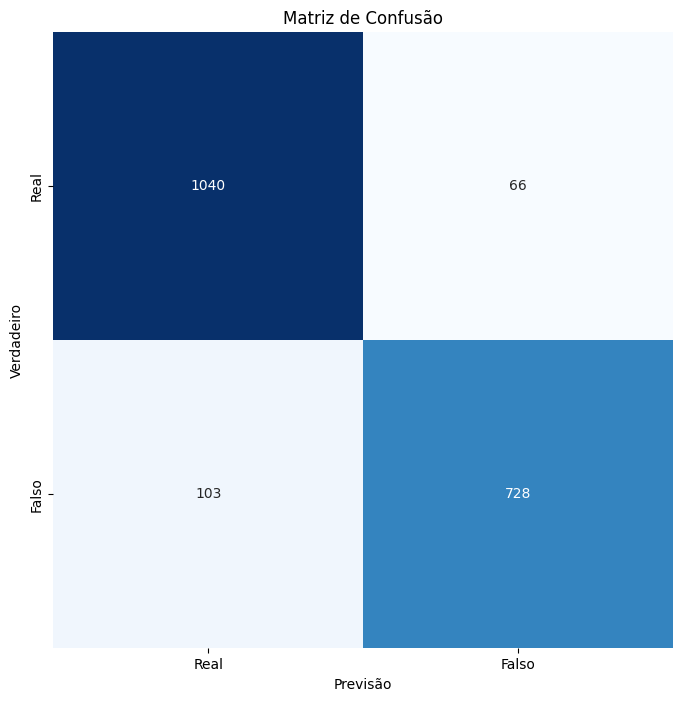

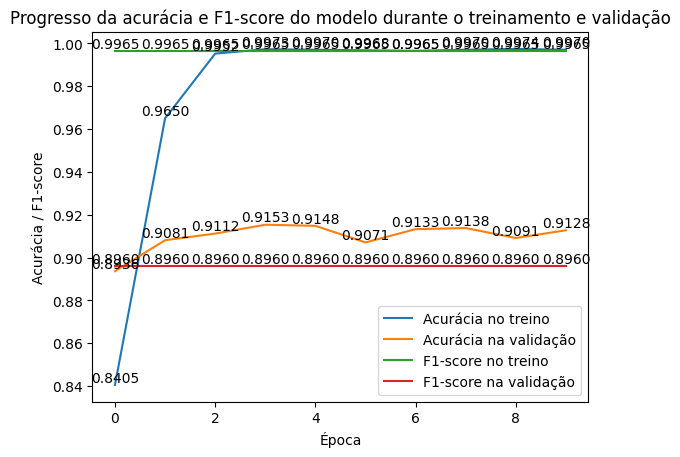

,Época,Acurácia na Validação,F1-score na Validação
0,1,0.893650,0.896
1,2,0.908105,0.896
2,3,0.911203,0.896
3,4,0.915333,0.896
4,5,0.914817,0.896
5,6,0.907073,0.896
6,7,0.913268,0.896
7,8,0.913784,0.896
8,9,0.909138,0.896
9,10,0.912752,0.896


In [10]:
#Obter os valores de F1-score
train_f1_scores, val_f1_scores = f1_score_metrics(fakeDETECTOR, history)

#Métrica de avaliação do modelo
print(metrics(fakeDETECTOR))

# Plotar  matriz de confusão
matriz_confusão(fakeDETECTOR)

# Plotar as metricas em cada época
plot_progresso(fakeDETECTOR, history)

#Resultado em um dataframe
results_toDataframe(history, fakeDETECTOR)

In [11]:
from tensorflow.keras.optimizers import Nadam

train_texts = X_train.astype(str)
val_texts = X_val.astype(str)
test_texts = X_test.astype(str)

max_sequence_length = 1000

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)

train_sequences = tokenizer.texts_to_sequences(train_texts)
train_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length)

val_sequences = tokenizer.texts_to_sequences(val_texts)
val_sequences = pad_sequences(val_sequences, maxlen=max_sequence_length)

test_sequences = tokenizer.texts_to_sequences(test_texts)
test_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length)

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 200

fakeDETECTOR2 = Sequential()
fakeDETECTOR2.add(Embedding(vocab_size, embedding_dim, input_length=max_sequence_length))
fakeDETECTOR2.add(Conv1D(256, 5, activation='relu'))
fakeDETECTOR2.add(GlobalMaxPooling1D())
fakeDETECTOR2.add(Dense(256, activation='relu'))
#fakeDETECTOR.add(Dense(128, activation='relu'))
fakeDETECTOR2.add(Dense(1, activation='sigmoid'))

fakeDETECTOR2.compile(optimizer='Nadam', loss='binary_crossentropy', metrics=['accuracy'])

history2 = fakeDETECTOR2.fit(train_sequences, y_train, epochs=4, batch_size=32, validation_data=(val_sequences, y_val))

loss, accuracy = fakeDETECTOR2.evaluate(val_sequences, y_val)
print("Acurácia: {:.2f}%".format(accuracy * 100))

Epoch 1/4
243/243 [==============================] - 473s 2s/step - loss: 0.3549 - accuracy: 0.8467 - val_loss: 0.2450 - val_accuracy: 0.8942
Epoch 2/4
243/243 [==============================] - 378s 2s/step - loss: 0.0868 - accuracy: 0.9706 - val_loss: 0.2696 - val_accuracy: 0.9014
Epoch 3/4
243/243 [==============================] - 352s 1s/step - loss: 0.0121 - accuracy: 0.9956 - val_loss: 0.2663 - val_accuracy: 0.9076
Epoch 4/4
61/61 [==============================] - 18s 293ms/step - loss: 0.2738 - accuracy: 0.9148
Acurácia: 91.48%


61/61 [==============================] - 19s 315ms/step
              precision    recall  f1-score   support

           0       0.91      0.94      0.93      1106
           1       0.92      0.88      0.90       831

    accuracy                           0.91      1937
   macro avg       0.92      0.91      0.91      1937
weighted avg       0.91      0.91      0.91      1937

61/61 [==============================] - 18s 293ms/step


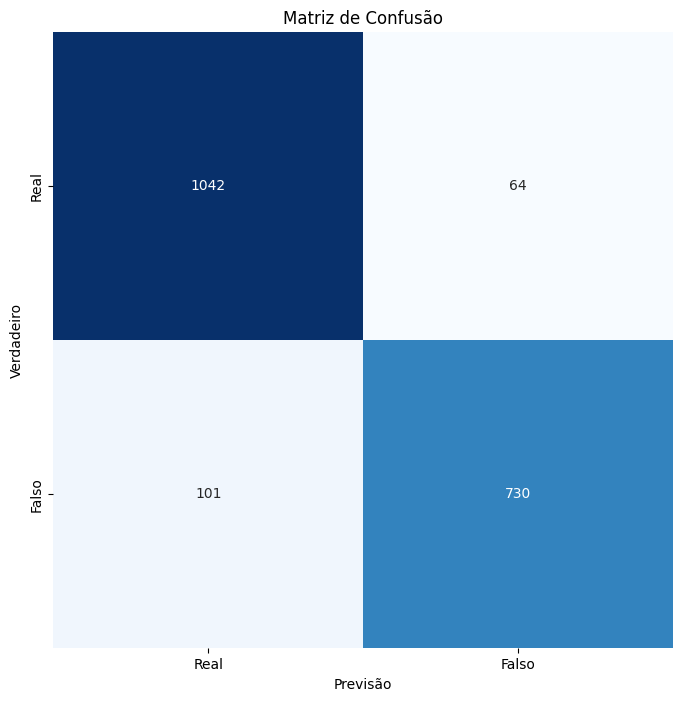

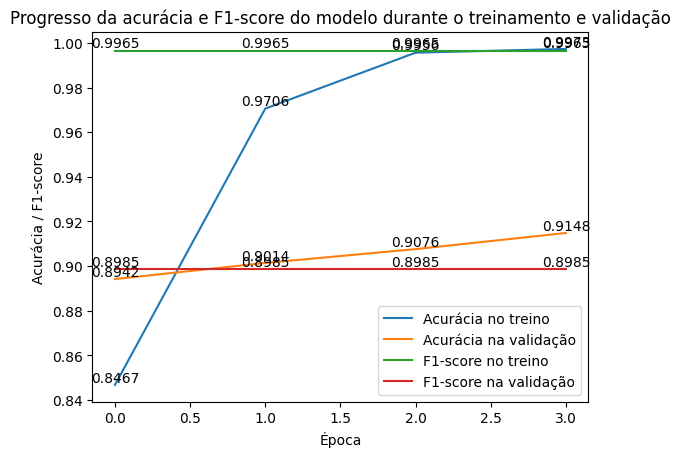

,Época,Acurácia na Validação,F1-score na Validação
0,1,0.894166,0.898462
1,2,0.901394,0.898462
2,3,0.907589,0.898462
3,4,0.914817,0.898462


In [12]:
#Obter os valores de F1-score
train_f1_scores, val_f1_scores = f1_score_metrics(fakeDETECTOR2, history2)

#Métrica de avaliação do modelo
print(metrics(fakeDETECTOR2))

# Plotar  matriz de confusão
matriz_confusão(fakeDETECTOR2)

# Plotar as metricas em cada época
plot_progresso(fakeDETECTOR2, history2)

#Resultado em um dataframe
results_toDataframe(history2, fakeDETECTOR2)

####Outros testes e anotações

In [ ]:
from tensorflow.keras.optimizers import Adagrad

fakeDETECTOR = Sequential()
fakeDETECTOR.add(Embedding(vocab_size, embedding_dim, input_length=max_sequence_length))
fakeDETECTOR.add(Conv1D(256, 5, activation='relu'))
fakeDETECTOR.add(GlobalMaxPooling1D())
fakeDETECTOR.add(Dense(256, activation='relu'))
fakeDETECTOR.add(Dense(1, activation='sigmoid'))

fakeDETECTOR.compile(optimizer=Adagrad(), loss='binary_crossentropy', metrics=['accuracy'])
fakeDETECTOR.fit(train_sequences, y_train, epochs=4, batch_size=32, validation_data=(val_sequences, y_val))

Epoch 1/4
243/243 [==============================] - 264s 1s/step - loss: 0.6892 - accuracy: 0.5654 - val_loss: 0.6861 - val_accuracy: 0.5710
Epoch 2/4
243/243 [==============================] - 257s 1s/step - loss: 0.6839 - accuracy: 0.5711 - val_loss: 0.6814 - val_accuracy: 0.5710
Epoch 3/4
243/243 [==============================] - 258s 1s/step - loss: 0.6796 - accuracy: 0.5711 - val_loss: 0.6773 - val_accuracy: 0.5710
Epoch 4/4
243/243 [==============================] - 257s 1s/step - loss: 0.6757 - accuracy: 0.5711 - val_loss: 0.6733 - val_accuracy: 0.5710


In [ ]:
from tensorflow.keras.optimizers import Adamax

fakeDETECTOR = Sequential()
fakeDETECTOR.add(Embedding(vocab_size, embedding_dim, input_length=max_sequence_length))
fakeDETECTOR.add(Conv1D(256, 5, activation='relu'))
fakeDETECTOR.add(GlobalMaxPooling1D())
fakeDETECTOR.add(Dense(256, activation='relu'))
fakeDETECTOR.add(Dense(1, activation='sigmoid'))

fakeDETECTOR.compile(optimizer=Adamax(), loss='binary_crossentropy', metrics=['accuracy'])
fakeDETECTOR.fit(train_sequences, y_train, epochs=4, batch_size=32, validation_data=(val_sequences, y_val))

Epoch 1/4
243/243 [==============================] - 326s 1s/step - loss: 0.4573 - accuracy: 0.8119 - val_loss: 0.3234 - val_accuracy: 0.8601
Epoch 2/4
243/243 [==============================] - 322s 1s/step - loss: 0.2527 - accuracy: 0.9001 - val_loss: 0.2705 - val_accuracy: 0.8818
Epoch 3/4
243/243 [==============================] - 342s 1s/step - loss: 0.1506 - accuracy: 0.9500 - val_loss: 0.2563 - val_accuracy: 0.8931
Epoch 4/4
243/243 [==============================] - 320s 1s/step - loss: 0.0696 - accuracy: 0.9824 - val_loss: 0.2367 - val_accuracy: 0.9050


In [ ]:
from tensorflow.keras.optimizers import Nadam

fakeDETECTOR = Sequential()
fakeDETECTOR.add(Embedding(vocab_size, embedding_dim, input_length=max_sequence_length))
fakeDETECTOR.add(Conv1D(256, 5, activation='relu'))
fakeDETECTOR.add(GlobalMaxPooling1D())
fakeDETECTOR.add(Dense(256, activation='relu'))
fakeDETECTOR.add(Dense(1, activation='sigmoid'))

fakeDETECTOR.compile(optimizer=Nadam(), loss='binary_crossentropy', metrics=['accuracy'])
fakeDETECTOR.fit(train_sequences, y_train, epochs=4, batch_size=32, validation_data=(val_sequences, y_val))

Epoch 1/4
243/243 [==============================] - 330s 1s/step - loss: 0.3534 - accuracy: 0.8445 - val_loss: 0.2381 - val_accuracy: 0.8942
Epoch 2/4
243/243 [==============================] - 329s 1s/step - loss: 0.0829 - accuracy: 0.9721 - val_loss: 0.2365 - val_accuracy: 0.9102
Epoch 3/4
243/243 [==============================] - 325s 1s/step - loss: 0.0110 - accuracy: 0.9965 - val_loss: 0.2912 - val_accuracy: 0.8931
Epoch 4/4
243/243 [==============================] - 324s 1s/step - loss: 0.0074 - accuracy: 0.9964 - val_loss: 0.2946 - val_accuracy: 0.8978


In [ ]:
from tensorflow.keras.optimizers import Nadam

fakeDETECTOR = Sequential()
fakeDETECTOR.add(Embedding(vocab_size, embedding_dim, input_length=max_sequence_length))
fakeDETECTOR.add(Conv1D(128, 5, activation='relu'))
fakeDETECTOR.add(GlobalMaxPooling1D())
fakeDETECTOR.add(Dense(128, activation='relu'))
fakeDETECTOR.add(Dense(1, activation='sigmoid'))

fakeDETECTOR.compile(optimizer=Nadam(), loss='binary_crossentropy', metrics=['accuracy'])
fakeDETECTOR.fit(train_sequences, y_train, epochs=2, batch_size=32, validation_data=(val_sequences, y_val))

loss, accuracy = fakeDETECTOR.evaluate(val_sequences, y_val)
print("Acurácia: {:.2f}%".format(accuracy * 100))

Epoch 1/2
243/243 [==============================] - 231s 941ms/step - loss: 0.3749 - accuracy: 0.8323 - val_loss: 0.2425 - val_accuracy: 0.8942
Epoch 2/2
61/61 [==============================] - 10s 170ms/step - loss: 0.2264 - accuracy: 0.9091
Acurácia: 90.91%


In [ ]:
#Apenas testes - deletar no final
train_texts = X_train.astype(str)
val_texts = X_val.astype(str)
test_texts = X_test.astype(str)

max_sequence_length = 200

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)

train_sequences = tokenizer.texts_to_sequences(train_texts)
train_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length)

val_sequences = tokenizer.texts_to_sequences(val_texts)
val_sequences = pad_sequences(val_sequences, maxlen=max_sequence_length)

test_sequences = tokenizer.texts_to_sequences(test_texts)
test_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length)

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100

fakeDETECTOR3 = Sequential()
fakeDETECTOR3.add(Embedding(vocab_size, embedding_dim, input_length=max_sequence_length))
fakeDETECTOR3.add(Conv1D(128, 3, activation='relu'))
fakeDETECTOR3.add(GlobalMaxPooling1D())
fakeDETECTOR3.add(Dense(128, activation='relu'))
fakeDETECTOR3.add(Dense(128, activation='relu'))
fakeDETECTOR3.add(Dense(1, activation='sigmoid'))

fakeDETECTOR3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history3 = fakeDETECTOR3.fit(train_sequences, y_train, epochs=10, batch_size=32, validation_data=(val_sequences, y_val))

loss, accuracy = fakeDETECTOR3.evaluate(val_sequences, y_val)
print("Acurácia: {:.2f}%".format(accuracy * 100))

Epoch 1/10
243/243 [==============================] - 35s 138ms/step - loss: 0.3754 - accuracy: 0.8395 - val_loss: 0.2828 - val_accuracy: 0.8833
Epoch 2/10
243/243 [==============================] - 33s 137ms/step - loss: 0.1373 - accuracy: 0.9502 - val_loss: 0.3870 - val_accuracy: 0.8539
Epoch 3/10
243/243 [==============================] - 33s 136ms/step - loss: 0.0253 - accuracy: 0.9902 - val_loss: 0.3451 - val_accuracy: 0.9024
Epoch 4/10
243/243 [==============================] - 33s 135ms/step - loss: 0.0061 - accuracy: 0.9972 - val_loss: 0.3608 - val_accuracy: 0.9040
Epoch 5/10
243/243 [==============================] - 33s 134ms/step - loss: 0.0055 - accuracy: 0.9966 - val_loss: 0.3805 - val_accuracy: 0.9045
Epoch 6/10
243/243 [==============================] - 34s 138ms/step - loss: 0.0058 - accuracy: 0.9973 - val_loss: 0.3838 - val_accuracy: 0.8911
Epoch 7/10
 85/243 [=========>....................] - ETA: 21s - loss: 0.0063 - accuracy: 0.9956

In [ ]:
#Obter os valores de F1-score
train_f1_scores, val_f1_scores = f1_score_metrics(fakeDETECTOR3, history3)

#Métrica de avaliação do modelo
print(metrics(fakeDETECTOR3))

# Plotar  matriz de confusão
matriz_confusão(fakeDETECTOR3)

# Plotar as metricas em cada época
plot_progresso(fakeDETECTOR3, history3)

#Resultado em um dataframe
results_toDataframe(history3, fakeDETECTOR3)

In [ ]:
history3.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

###Fazendo previsões utilizando o modelo fakeDETECTOR

In [ ]:
text = "O aparecimento de surtos de Covid-19 em diferentes coros levantou a"
#text = "Infelizmente é confirmado ‘acaba de falecer’. Apresentador José Luiz Datena (com letras pequenas) sofre perda e está de (com letras grandes) Luto. LUT0: Infelizmente Nosso amado Datena da Band, horas após cirurgia delicada recebe pior das notícias"

text = text.lower()
text = re.sub(r"[^\w\s]", "", text)
text_sequence = tokenizer.texts_to_sequences([text])
text_sequence = pad_sequences(text_sequence, maxlen=max_sequence_length)
prediction = fakeDETECTOR.predict(text_sequence)
#prediction = fakeDETECTOR.predict_classes(text_sequence)
prediction_classes = (prediction > 0.5).astype(int)
print(prediction_classes[0][0])

1/1 [==============================] - 0s 44ms/step
1


###Salvando o modelo treinado

In [ ]:
fakeDETECTOR.save('/content/modelo/fakeDETECTOR.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#!pip install tensorflowjs
import tensorflowjs as tfjs

# Caminho para o modelo .h5
h5_path = '/content/modelo/fakeDETECTOR.h5'

# Caminho de destino para salvar o modelo convertido
output_path = '/content/'

# Converter o modelo
tfjs.converters.save_keras_model(model, output_path)